# TensorFlow implementation of "A Neural Algorithm of Artistic Style"



With their 2015 paper, Gatys et al. allow us to do a bit of time travelling and invite our favorite artists to paint a scenery we love or portraits of family members.

They showed that we could use Convolution Neural Networks to mix the content of an image with the style of another.

They used the pretrained VGG-Network CNN, its 16 convolutional and 5 pooling layers. 

Reconstruction of the content image: lower layers simply reproduce the exact pixel values of the original image. Higher layers in the network capture the high level content in terms of objects and their arrangement in the input image. Hence we use the 4th convolution layer

To extract the style of an image, we compute the correlations between the different filter responses over the multiple layers. We obtain a multi-scale representation that captures the texture but not the arrangement of objects. 



## Install Pillow

In [2]:
!pip3 install h5py

  Using cached h5py-2.7.0-cp35-cp35m-manylinux1_x86_64.whl
  Using cached six-1.10.0-py2.py3-none-any.whl
  Using cached numpy-1.12.1-cp35-cp35m-manylinux1_x86_64.whl
You are using pip version 8.1.1, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Load Libraries

In [3]:
import os
import sys
import numpy as np
import scipy.io
import scipy.misc
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
%matplotlib inline

## Paths and parameters

In [4]:
img_style_original_path = 'VanGogh_StarryNight.jpg' #'Monet Saint Georges.jpg' #'chagall.jpg' #'renoir.jpg' #'VanGogh_StarryNight.jpg'   #'Picasso.jpg'  #'Kandinsky.jpg'
img_content_original_path = 'Central Park.jpg' #'raphraph.png' #'Central Park.jpg'  #'Raphael.jpg'
image_size = (800,600)
rgb_grey = 3        # = 1 if grey, 3 if color

#Download imagenet-vgg-verydeep-19.mat from http://www.vlfeat.org/matconvnet/pretrained/#downloading-the-pre-trained-models
vgg_path =  'imagenet-vgg-verydeep-19.mat'

# % of weight of noise in the input image
noise_ratio = 0.6    

# weighting factors for content and style reconstruction
alpha = 5       # weight of the style loss
beta = 1000     # weight of the content loss

# The higher the weight of the higher layers and lower the weight of the lower layers, the softer the features:
style_layers = [
    ('conv1_1', 0.5),
    ('conv2_1', 1.0),
    ('conv3_1', 1.5),
    ('conv4_1', 3.0),
    ('conv5_1', 4.0),
]

content_layer = 'conv5_2'

# VGG19 model requires us to de-mean the images with those values:
mean_values = np.array([123.68,116.779,103.939]).reshape((1,1,1,3))

# Number of iterations to run.
iterations = 200  


## Load and Save functions

In [5]:
def load_image(path):
    image = scipy.misc.imread(path)
    image = np.reshape(image, ((1,) + image.shape))  # need format (1, w, h, 3) for VGG model
    image = image - mean_values                      
    return image

def save_image(path, image):
    image = image + mean_values
    image = image[0]
    image = np.clip(image, 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

## Style Image: 

"The artist must train not only his eye but also his soul" (Kandinsky)

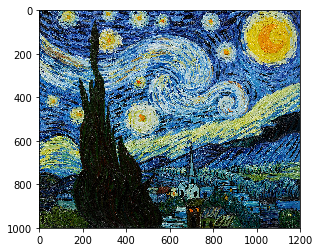

In [6]:
img_original_style = Image.open(img_style_original_path)
img_resized_style = img_original_style.resize(image_size, Image.ANTIALIAS)
img_resized_style.save("resized_"+img_style_original_path)
plt.imshow(img_original_style)
plt.show()

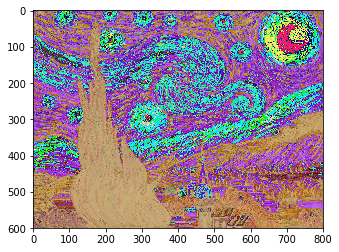

In [7]:
img_style = load_image("resized_"+img_style_original_path)
plt.imshow(img_style[0])
plt.show()

## Content Image:

### Original image:

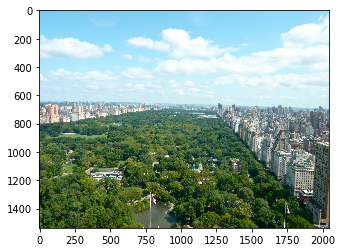

In [8]:
img_original_content = Image.open(img_content_original_path)
img_resized_content = img_original_content.resize(image_size, Image.ANTIALIAS)
img_resized_content.save("resized_"+img_content_original_path)
plt.imshow(img_original_content)
plt.show()

### De-meaned image:

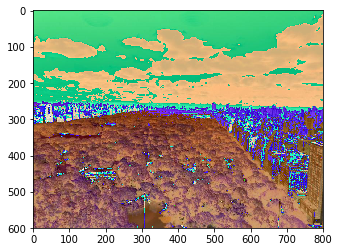

In [9]:
img_content = load_image("resized_"+img_content_original_path)
plt.imshow(img_content[0])
plt.show()

## Generate Input (= 60% Noise + 40% Style) Image

White noise allows us to generate every time a different output; with a fixed image we would always converge to the same output.

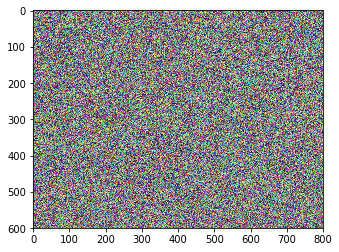

In [10]:
def generate_noise_image(img_content, noise_ratio = noise_ratio):
    img_noise = np.random.uniform(-20, 20, (1, image_size[1], image_size[0], rgb_grey)).astype('float32')
    img_input = img_noise * noise_ratio + img_content * (1 - noise_ratio)
    return img_input

img_input = generate_noise_image(img_content)
plt.imshow(img_input[0])
plt.show()

## Graph construction:

Takes only the convolution layer weights and wrap using the TensorFlow
Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
the paper indicates that using AveragePooling yields better results.
The last few fully connected layers are not used.
Here is the detailed configuration of the VGG model:

In [11]:
def generate_vgg_model(path):
    
    vgg = scipy.io.loadmat(path)
    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b 
        
    def _relu(conv2d_layer):
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, image_size[1], image_size[0], rgb_grey)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    return graph

vgg_path =  'imagenet-vgg-verydeep-19.mat'
model = generate_vgg_model(vgg_path)
model

{'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 300, 400, 64) dtype=float32>,
 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 150, 200, 128) dtype=float32>,
 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 75, 100, 256) dtype=float32>,
 'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 38, 50, 512) dtype=float32>,
 'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 19, 25, 512) dtype=float32>,
 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 600, 800, 64) dtype=float32>,
 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 600, 800, 64) dtype=float32>,
 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 300, 400, 128) dtype=float32>,
 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 300, 400, 128) dtype=float32>,
 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 150, 200, 256) dtype=float32>,
 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 150, 200, 256) dtype=float32>,
 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 150, 200, 256) dtype=float32>,
 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 150, 200, 256) dtype=float32>,
 'conv4_1': <tf.T

## Loss Functions

### Content loss

Let $p$ and $x$ be the content image and the generated image and $P^l$ and $F^l$ their respective feature representations in layer $l$. The loss is the squared error loss of the feature representation of the two images for the particular layer. Here, a high level layer, conv5_2.


$$L_{content}(p, x, l) = 1/2 *\sum_{i,j} (F^l_{ij} − P^l_{ij})^2$$

We can change the initially random image $x$ until it generates the same response in the layer conv5_2 of the CNN as the original image $p$. 

### Style loss

We built a style representation that computes the correlations between the different filter responses of each layer.

$$Gram^l_{ij} = \sum F^l_{i,k}F^l_{jk}$$

To generate a texture that matches the style of a given image, we use gradient descent from a white noise image to ﬁnd another image that matches the style representation of the original image. This is done by minimising the mean-squared distance between the entries of the Gram matrix from the original image and the Gram matrix of the image to be generated.

$$ E_l = \frac{1}{4 N_l^2 M^2_l} \sum_{i,j} (G_{ij}^l-A^l_{ij})^2$$

$$ L_{style}(a,x) = \sum_l w_t E_t $$

### Total loss 

To generate the images that mix the content of a photograph with the style of a painting we jointly minimise the distance of a white noise image from the content representation of the photograph in one layer of the network and the style representation of the painting in a number of layers of the CNN.

So let $p$ be the photograph and $a$ be the artwork. The loss function we minimise is:

$$L_{total} = \alpha L_{content}(p,x) + \beta L_{style}(a,x) $$


In [12]:
def content_loss(p,x):
    N = p.shape[3]              # number of filters (at layer l).
    M = p.shape[1] * p.shape[2] # height * width of the feature map (at layer l).    
    # loss = 0.5 * tf.reduce_sum(tf.pow(x - p, 2)) #the article content_loss function
    # loss = (1./(2* N**0.5 * M**0.5)) * tf.reduce_sum(tf.pow(x - p, 2)) 
    loss = (1. / (4 * N * M)) * tf.reduce_sum(tf.pow(x - p, 2)) 
    return loss

def style_loss_func(sess, model):

    def _gram_matrix(F, N, M):
        Ft = tf.reshape(F, (M, N))
        return tf.matmul(tf.transpose(Ft), Ft) 

    def _style_loss(a, x):
        N = a.shape[3]
        M = a.shape[1] * a.shape[2]
        A = _gram_matrix(a, N, M) # A is the style representation of the original image (at layer l).
        G = _gram_matrix(x, N, M) # G is the style representation of the generated image (at layer l).
        E_l = (1 / (4 * N**2 * M**2)) * tf.reduce_sum(tf.pow(G - A, 2))
        return E_l

    E = [_style_loss(sess.run(model[layer_name]), model[layer_name]) for layer_name, _ in style_layers]
    W = [layer_weight for _, layer_weight in style_layers]
    loss = sum([W[l] * E[l] for l in range(len(style_layers))])
    return loss

## Launching


In [13]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# Content_loss using content_image.
sess.run(model['input'].assign(img_content))
content_loss = content_loss(sess.run(model[content_layer]), model[content_layer]) 

# Construct style_loss using style_image.
sess.run(model['input'].assign(img_style))
style_loss = style_loss_func(sess, model)

total_loss = alpha * content_loss + beta * style_loss

optimizer = tf.train.AdamOptimizer(2.0)
train = optimizer.minimize(total_loss)

## Iterations

In [14]:
import time

sess.run(tf.global_variables_initializer())
sess.run(model['input'].assign(img_input))
t0 = time.time()
for it in range(iterations+1):
    start_time = time.time()
    sess.run(train)
    if it%200 == 0:
        # Print every 200 iteration.
        img_mixed = sess.run(model['input'])
        print('Iteration %d' % (it))
        print('sum : ', sess.run(tf.reduce_sum(img_mixed)))
        print('cost: ', sess.run(total_loss))

        filename = 'output/%d.png' % (it)
        save_image(filename, img_mixed)
        t1 = time.time()
        print("Time to run 200 iterations:", round(t1 - t0,0))
        t0 = t1

Iteration 0
sum :  1.78811e+07
cost:  6.05809e+12
Time to run 200 iterations: 8.0
Iteration 200
sum :  1.45354e+07
cost:  3.31776e+10
Time to run 200 iterations: 189.0


## Outputs

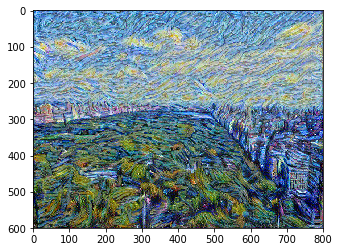

In [16]:
img_final_CP_VG = Image.open("final/Central Park by Van Gogh.png")
plt.imshow(img_final_CP_VG)
plt.show()

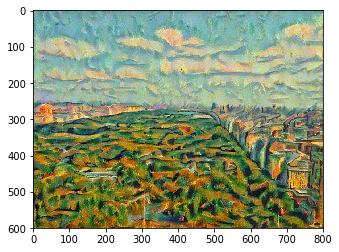

In [17]:
img_final_CP_CZ = Image.open("final/Central Park by Cezanne.png")
plt.imshow(img_final_CP_CZ)
plt.show()

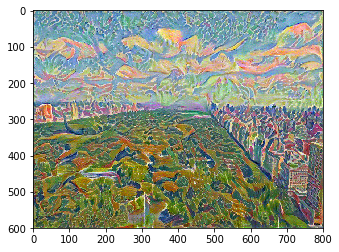

In [18]:
img_final_CP_MT = Image.open("final/Central Park by Matisse.png")
plt.imshow(img_final_CP_MT)
plt.show()

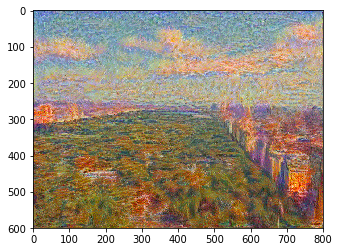

In [19]:
img_final_CP_MN = Image.open("final/Central Park by Monet.png")
plt.imshow(img_final_CP_MN)
plt.show()